In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5, 7"

In [49]:
dataset = pd.read_csv('../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [50]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [51]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [52]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [53]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [54]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [55]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [56]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [57]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [58]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [59]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [60]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [61]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [62]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [63]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [64]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [65]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [66]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [67]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [68]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [69]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [70]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [71]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [72]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [73]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [74]:
# n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
# n_obs

### Split into input and outputs

In [75]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [76]:
# vis_train_X = train_X
# vis_test_X = test_X

### Normalization

In [77]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

In [78]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


In [79]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features, 1))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features, 1))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28, 1) (77069, 96) (19268, 72, 28, 1) (19268, 96)


### Model

In [35]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2], train_X.shape[3]))

# 4 cnn with skip connection
x1 = layers.Conv2D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv2D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([model_input, x1])

x1 = layers.Conv2D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)

x1_merge3 = concatenate([model_input, x1])

x1 = layers.Conv2D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)


# # 4 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input[:, :, :, 0])
x2_merge1 = concatenate([model_input[:, :, :, 0], x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)

x2_merge2 = concatenate([model_input[:, :, :, 0], x2])

x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)

x2_merge3 = concatenate([model_input[:, :, :, 0], x2])

x2 = layers.SimpleRNN(28, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge3)

x2 = layers.Reshape((train_X.shape[1], train_X.shape[2], 1))(x2)



merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# # x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# # x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# # x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# # x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)


ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28, 1)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_4 (Te [(None, 72, 28)]     0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_5 (Te [(None, 72, 28)]     0           input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        (None, 72, 128)      20096       tf_op_layer_strided_slice_4[0][0]
____________________________________________________________________________________________

In [36]:
lr = 0.0001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1500)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc1_4layer_{}h_2D_S24.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

Epoch 1/6000


2023-02-01 16:16:40.144977: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-01 16:16:40.361484: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-02-01 16:16:41.490317: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-02-01 16:16:41.948352: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.04675, saving model to saved_model/ws_pararcnn_sc1_4layer_24h_2D.h5
151/151 - 119s - loss: 0.0834 - mae: 0.0467 - val_loss: 0.0590 - val_mae: 0.0467
Epoch 2/6000

Epoch 00002: val_mae improved from 0.04675 to 0.03217, saving model to saved_model/ws_pararcnn_sc1_4layer_24h_2D.h5
151/151 - 66s - loss: 0.0466 - mae: 0.0214 - val_loss: 0.0396 - val_mae: 0.0322
Epoch 3/6000

Epoch 00003: val_mae improved from 0.03217 to 0.02606, saving model to saved_model/ws_pararcnn_sc1_4layer_24h_2D.h5
151/151 - 67s - loss: 0.0334 - mae: 0.0154 - val_loss: 0.0299 - val_mae: 0.0261
Epoch 4/6000

Epoch 00004: val_mae improved from 0.02606 to 0.02284, saving model to saved_model/ws_pararcnn_sc1_4layer_24h_2D.h5
151/151 - 67s - loss: 0.0262 - mae: 0.0131 - val_loss: 0.0241 - val_mae: 0.0228
Epoch 5/6000

Epoch 00005: val_mae improved from 0.02284 to 0.02232, saving model to saved_model/ws_pararcnn_sc1_4layer_24h_2D.h5
151/151 - 67s - loss: 0.0215 - mae: 0.0120 - v

Epoch 51/6000

Epoch 00051: val_mae did not improve from 0.01456
151/151 - 66s - loss: 3.8836e-04 - mae: 0.0082 - val_loss: 7.0070e-04 - val_mae: 0.0160
Epoch 52/6000

Epoch 00052: val_mae did not improve from 0.01456
151/151 - 68s - loss: 3.7410e-04 - mae: 0.0081 - val_loss: 7.1562e-04 - val_mae: 0.0169
Epoch 53/6000

Epoch 00053: val_mae did not improve from 0.01456
151/151 - 71s - loss: 3.5908e-04 - mae: 0.0080 - val_loss: 7.4283e-04 - val_mae: 0.0174
Epoch 54/6000

Epoch 00054: val_mae did not improve from 0.01456
151/151 - 71s - loss: 3.4726e-04 - mae: 0.0080 - val_loss: 7.1733e-04 - val_mae: 0.0175
Epoch 55/6000

Epoch 00055: val_mae did not improve from 0.01456
151/151 - 71s - loss: 3.3892e-04 - mae: 0.0080 - val_loss: 5.9567e-04 - val_mae: 0.0154
Epoch 56/6000

Epoch 00056: val_mae did not improve from 0.01456
151/151 - 71s - loss: 3.3270e-04 - mae: 0.0082 - val_loss: 6.1537e-04 - val_mae: 0.0158
Epoch 57/6000

Epoch 00057: val_mae did not improve from 0.01456
151/151 - 71s - l

Epoch 104/6000

Epoch 00104: val_mae did not improve from 0.01334
151/151 - 67s - loss: 2.5968e-04 - mae: 0.0075 - val_loss: 4.7538e-04 - val_mae: 0.0139
Epoch 105/6000

Epoch 00105: val_mae did not improve from 0.01334
151/151 - 67s - loss: 2.6226e-04 - mae: 0.0076 - val_loss: 5.5916e-04 - val_mae: 0.0153
Epoch 106/6000

Epoch 00106: val_mae did not improve from 0.01334
151/151 - 67s - loss: 2.6358e-04 - mae: 0.0076 - val_loss: 4.7842e-04 - val_mae: 0.0138
Epoch 107/6000

Epoch 00107: val_mae did not improve from 0.01334
151/151 - 67s - loss: 2.5826e-04 - mae: 0.0074 - val_loss: 4.7281e-04 - val_mae: 0.0139
Epoch 108/6000

Epoch 00108: val_mae did not improve from 0.01334
151/151 - 67s - loss: 2.5951e-04 - mae: 0.0075 - val_loss: 5.4262e-04 - val_mae: 0.0151
Epoch 109/6000

Epoch 00109: val_mae improved from 0.01334 to 0.01327, saving model to saved_model/ws_pararcnn_sc1_4layer_24h_2D.h5
151/151 - 67s - loss: 2.6117e-04 - mae: 0.0075 - val_loss: 4.3996e-04 - val_mae: 0.0133
Epoch 110/


Epoch 00155: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.4745e-04 - mae: 0.0071 - val_loss: 4.8987e-04 - val_mae: 0.0139
Epoch 156/6000

Epoch 00156: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.5112e-04 - mae: 0.0073 - val_loss: 4.8135e-04 - val_mae: 0.0139
Epoch 157/6000

Epoch 00157: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.5109e-04 - mae: 0.0073 - val_loss: 4.1754e-04 - val_mae: 0.0124
Epoch 158/6000

Epoch 00158: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.5279e-04 - mae: 0.0073 - val_loss: 4.2609e-04 - val_mae: 0.0127
Epoch 159/6000

Epoch 00159: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.5064e-04 - mae: 0.0073 - val_loss: 5.0991e-04 - val_mae: 0.0146
Epoch 160/6000

Epoch 00160: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.4759e-04 - mae: 0.0071 - val_loss: 5.0439e-04 - val_mae: 0.0142
Epoch 161/6000

Epoch 00161: val_mae did not improve from 0.01233
151/151 - 66s - loss: 2.4

Epoch 208/6000

Epoch 00208: val_mae did not improve from 0.01178
151/151 - 66s - loss: 2.4024e-04 - mae: 0.0069 - val_loss: 4.4054e-04 - val_mae: 0.0129
Epoch 209/6000

Epoch 00209: val_mae did not improve from 0.01178
151/151 - 66s - loss: 2.4431e-04 - mae: 0.0071 - val_loss: 4.0675e-04 - val_mae: 0.0124
Epoch 210/6000

Epoch 00210: val_mae did not improve from 0.01178
151/151 - 66s - loss: 2.4352e-04 - mae: 0.0070 - val_loss: 4.5272e-04 - val_mae: 0.0133
Epoch 211/6000

Epoch 00211: val_mae did not improve from 0.01178
151/151 - 67s - loss: 2.4252e-04 - mae: 0.0070 - val_loss: 4.9305e-04 - val_mae: 0.0140
Epoch 212/6000

Epoch 00212: val_mae did not improve from 0.01178
151/151 - 66s - loss: 2.4081e-04 - mae: 0.0069 - val_loss: 4.6198e-04 - val_mae: 0.0135
Epoch 213/6000

Epoch 00213: val_mae did not improve from 0.01178
151/151 - 66s - loss: 2.4374e-04 - mae: 0.0071 - val_loss: 5.0734e-04 - val_mae: 0.0145
Epoch 214/6000

Epoch 00214: val_mae did not improve from 0.01178
151/151 - 

Epoch 261/6000

Epoch 00261: val_mae did not improve from 0.01166
151/151 - 66s - loss: 2.3429e-04 - mae: 0.0067 - val_loss: 4.3747e-04 - val_mae: 0.0129
Epoch 262/6000

Epoch 00262: val_mae did not improve from 0.01166
151/151 - 66s - loss: 2.3947e-04 - mae: 0.0070 - val_loss: 4.2957e-04 - val_mae: 0.0127
Epoch 263/6000

Epoch 00263: val_mae did not improve from 0.01166
151/151 - 66s - loss: 2.3702e-04 - mae: 0.0069 - val_loss: 4.3586e-04 - val_mae: 0.0129
Epoch 264/6000

Epoch 00264: val_mae did not improve from 0.01166
151/151 - 66s - loss: 2.3507e-04 - mae: 0.0068 - val_loss: 4.2186e-04 - val_mae: 0.0126
Epoch 265/6000

Epoch 00265: val_mae did not improve from 0.01166
151/151 - 66s - loss: 2.3820e-04 - mae: 0.0069 - val_loss: 4.2575e-04 - val_mae: 0.0127
Epoch 266/6000

Epoch 00266: val_mae did not improve from 0.01166
151/151 - 66s - loss: 2.4077e-04 - mae: 0.0070 - val_loss: 5.0761e-04 - val_mae: 0.0148
Epoch 267/6000

Epoch 00267: val_mae did not improve from 0.01166
151/151 - 

Epoch 314/6000

Epoch 00314: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.3286e-04 - mae: 0.0068 - val_loss: 4.5660e-04 - val_mae: 0.0130
Epoch 315/6000

Epoch 00315: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.3274e-04 - mae: 0.0067 - val_loss: 3.7831e-04 - val_mae: 0.0116
Epoch 316/6000

Epoch 00316: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.3325e-04 - mae: 0.0068 - val_loss: 4.3973e-04 - val_mae: 0.0131
Epoch 317/6000

Epoch 00317: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.3349e-04 - mae: 0.0068 - val_loss: 3.9550e-04 - val_mae: 0.0119
Epoch 318/6000

Epoch 00318: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.3340e-04 - mae: 0.0068 - val_loss: 4.5668e-04 - val_mae: 0.0132
Epoch 319/6000

Epoch 00319: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.3398e-04 - mae: 0.0068 - val_loss: 4.0879e-04 - val_mae: 0.0123
Epoch 320/6000

Epoch 00320: val_mae did not improve from 0.01118
151/151 - 

Epoch 368/6000

Epoch 00368: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2910e-04 - mae: 0.0067 - val_loss: 4.6258e-04 - val_mae: 0.0132
Epoch 369/6000

Epoch 00369: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.3017e-04 - mae: 0.0067 - val_loss: 4.0272e-04 - val_mae: 0.0120
Epoch 370/6000

Epoch 00370: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2916e-04 - mae: 0.0067 - val_loss: 4.2354e-04 - val_mae: 0.0124
Epoch 371/6000

Epoch 00371: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.3081e-04 - mae: 0.0067 - val_loss: 4.3605e-04 - val_mae: 0.0127
Epoch 372/6000

Epoch 00372: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2952e-04 - mae: 0.0067 - val_loss: 4.4100e-04 - val_mae: 0.0129
Epoch 373/6000

Epoch 00373: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.3249e-04 - mae: 0.0068 - val_loss: 4.4464e-04 - val_mae: 0.0130
Epoch 374/6000

Epoch 00374: val_mae did not improve from 0.01118
151/151 - 

Epoch 422/6000

Epoch 00422: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.2555e-04 - mae: 0.0066 - val_loss: 4.4468e-04 - val_mae: 0.0128
Epoch 423/6000

Epoch 00423: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2558e-04 - mae: 0.0066 - val_loss: 4.2355e-04 - val_mae: 0.0126
Epoch 424/6000

Epoch 00424: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.2521e-04 - mae: 0.0066 - val_loss: 4.1241e-04 - val_mae: 0.0121
Epoch 425/6000

Epoch 00425: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2747e-04 - mae: 0.0067 - val_loss: 4.2403e-04 - val_mae: 0.0125
Epoch 426/6000

Epoch 00426: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2564e-04 - mae: 0.0066 - val_loss: 4.2907e-04 - val_mae: 0.0128
Epoch 427/6000

Epoch 00427: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.2919e-04 - mae: 0.0067 - val_loss: 3.8858e-04 - val_mae: 0.0118
Epoch 428/6000

Epoch 00428: val_mae did not improve from 0.01118
151/151 - 

Epoch 476/6000

Epoch 00476: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2726e-04 - mae: 0.0067 - val_loss: 4.1794e-04 - val_mae: 0.0122
Epoch 477/6000

Epoch 00477: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.2270e-04 - mae: 0.0065 - val_loss: 3.8299e-04 - val_mae: 0.0118
Epoch 478/6000

Epoch 00478: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.2440e-04 - mae: 0.0066 - val_loss: 4.5219e-04 - val_mae: 0.0130
Epoch 479/6000

Epoch 00479: val_mae did not improve from 0.01118
151/151 - 66s - loss: 2.2195e-04 - mae: 0.0065 - val_loss: 4.0963e-04 - val_mae: 0.0122
Epoch 480/6000

Epoch 00480: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2210e-04 - mae: 0.0065 - val_loss: 4.3645e-04 - val_mae: 0.0126
Epoch 481/6000

Epoch 00481: val_mae did not improve from 0.01118
151/151 - 67s - loss: 2.2669e-04 - mae: 0.0067 - val_loss: 3.9414e-04 - val_mae: 0.0119
Epoch 482/6000

Epoch 00482: val_mae improved from 0.01118 to 0.01098, savin

Epoch 530/6000

Epoch 00530: val_mae did not improve from 0.01098
151/151 - 67s - loss: 2.2169e-04 - mae: 0.0065 - val_loss: 4.3769e-04 - val_mae: 0.0130
Epoch 531/6000

Epoch 00531: val_mae did not improve from 0.01098
151/151 - 66s - loss: 2.2299e-04 - mae: 0.0066 - val_loss: 4.2645e-04 - val_mae: 0.0124
Epoch 532/6000

Epoch 00532: val_mae did not improve from 0.01098
151/151 - 67s - loss: 2.1994e-04 - mae: 0.0064 - val_loss: 4.5269e-04 - val_mae: 0.0132
Epoch 533/6000

Epoch 00533: val_mae did not improve from 0.01098
151/151 - 66s - loss: 2.2407e-04 - mae: 0.0066 - val_loss: 3.6702e-04 - val_mae: 0.0112
Epoch 534/6000

Epoch 00534: val_mae did not improve from 0.01098
151/151 - 66s - loss: 2.1758e-04 - mae: 0.0063 - val_loss: 4.4183e-04 - val_mae: 0.0129
Epoch 535/6000

Epoch 00535: val_mae did not improve from 0.01098
151/151 - 66s - loss: 2.2255e-04 - mae: 0.0066 - val_loss: 4.3472e-04 - val_mae: 0.0128
Epoch 536/6000

Epoch 00536: val_mae did not improve from 0.01098
151/151 - 

Epoch 584/6000

Epoch 00584: val_mae did not improve from 0.01098
151/151 - 70s - loss: 2.1737e-04 - mae: 0.0064 - val_loss: 3.7641e-04 - val_mae: 0.0116
Epoch 585/6000

Epoch 00585: val_mae did not improve from 0.01098
151/151 - 81s - loss: 2.1676e-04 - mae: 0.0063 - val_loss: 4.5244e-04 - val_mae: 0.0128
Epoch 586/6000

Epoch 00586: val_mae did not improve from 0.01098
151/151 - 81s - loss: 2.1909e-04 - mae: 0.0065 - val_loss: 4.9187e-04 - val_mae: 0.0133
Epoch 587/6000

Epoch 00587: val_mae did not improve from 0.01098
151/151 - 81s - loss: 2.2298e-04 - mae: 0.0066 - val_loss: 3.9639e-04 - val_mae: 0.0118
Epoch 588/6000

Epoch 00588: val_mae did not improve from 0.01098
151/151 - 81s - loss: 2.1787e-04 - mae: 0.0064 - val_loss: 4.1917e-04 - val_mae: 0.0126
Epoch 589/6000

Epoch 00589: val_mae did not improve from 0.01098
151/151 - 79s - loss: 2.1929e-04 - mae: 0.0065 - val_loss: 4.6363e-04 - val_mae: 0.0136
Epoch 590/6000

Epoch 00590: val_mae did not improve from 0.01098
151/151 - 

Epoch 640/6000

Epoch 00640: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1719e-04 - mae: 0.0064 - val_loss: 4.1903e-04 - val_mae: 0.0124
Epoch 641/6000

Epoch 00641: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1626e-04 - mae: 0.0064 - val_loss: 4.4448e-04 - val_mae: 0.0128
Epoch 642/6000

Epoch 00642: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1880e-04 - mae: 0.0065 - val_loss: 4.0777e-04 - val_mae: 0.0121
Epoch 643/6000

Epoch 00643: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1492e-04 - mae: 0.0063 - val_loss: 4.4463e-04 - val_mae: 0.0127
Epoch 644/6000

Epoch 00644: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1648e-04 - mae: 0.0064 - val_loss: 4.5181e-04 - val_mae: 0.0136
Epoch 645/6000

Epoch 00645: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1704e-04 - mae: 0.0064 - val_loss: 4.3906e-04 - val_mae: 0.0128
Epoch 646/6000

Epoch 00646: val_mae did not improve from 0.01084
151/151 - 

Epoch 694/6000

Epoch 00694: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1199e-04 - mae: 0.0062 - val_loss: 4.0322e-04 - val_mae: 0.0119
Epoch 695/6000

Epoch 00695: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1388e-04 - mae: 0.0063 - val_loss: 4.2852e-04 - val_mae: 0.0126
Epoch 696/6000

Epoch 00696: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1942e-04 - mae: 0.0066 - val_loss: 4.3507e-04 - val_mae: 0.0125
Epoch 697/6000

Epoch 00697: val_mae did not improve from 0.01084
151/151 - 67s - loss: 2.1614e-04 - mae: 0.0064 - val_loss: 3.7970e-04 - val_mae: 0.0116
Epoch 698/6000

Epoch 00698: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1267e-04 - mae: 0.0062 - val_loss: 4.6950e-04 - val_mae: 0.0134
Epoch 699/6000

Epoch 00699: val_mae did not improve from 0.01084
151/151 - 66s - loss: 2.1395e-04 - mae: 0.0063 - val_loss: 3.9719e-04 - val_mae: 0.0119
Epoch 700/6000

Epoch 00700: val_mae did not improve from 0.01084
151/151 - 

Epoch 749/6000

Epoch 00749: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.1318e-04 - mae: 0.0063 - val_loss: 4.2262e-04 - val_mae: 0.0125
Epoch 750/6000

Epoch 00750: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.1572e-04 - mae: 0.0064 - val_loss: 4.5763e-04 - val_mae: 0.0130
Epoch 751/6000

Epoch 00751: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.1535e-04 - mae: 0.0065 - val_loss: 4.6685e-04 - val_mae: 0.0135
Epoch 752/6000

Epoch 00752: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0875e-04 - mae: 0.0061 - val_loss: 3.7850e-04 - val_mae: 0.0117
Epoch 753/6000

Epoch 00753: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.1293e-04 - mae: 0.0063 - val_loss: 4.0849e-04 - val_mae: 0.0121
Epoch 754/6000

Epoch 00754: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.1076e-04 - mae: 0.0062 - val_loss: 4.1085e-04 - val_mae: 0.0122
Epoch 755/6000

Epoch 00755: val_mae did not improve from 0.01068
151/151 - 

Epoch 837/6000

Epoch 00837: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.1096e-04 - mae: 0.0063 - val_loss: 4.6634e-04 - val_mae: 0.0135
Epoch 838/6000

Epoch 00838: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0911e-04 - mae: 0.0062 - val_loss: 4.3198e-04 - val_mae: 0.0128
Epoch 839/6000

Epoch 00839: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.1069e-04 - mae: 0.0063 - val_loss: 4.2682e-04 - val_mae: 0.0125
Epoch 840/6000

Epoch 00840: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0969e-04 - mae: 0.0063 - val_loss: 4.8006e-04 - val_mae: 0.0134
Epoch 841/6000

Epoch 00841: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.1154e-04 - mae: 0.0063 - val_loss: 3.9894e-04 - val_mae: 0.0122
Epoch 842/6000

Epoch 00842: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0931e-04 - mae: 0.0062 - val_loss: 4.4599e-04 - val_mae: 0.0127
Epoch 843/6000

Epoch 00843: val_mae did not improve from 0.01068
151/151 - 

Epoch 891/6000

Epoch 00891: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0961e-04 - mae: 0.0063 - val_loss: 4.2089e-04 - val_mae: 0.0124
Epoch 892/6000

Epoch 00892: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.0774e-04 - mae: 0.0062 - val_loss: 3.9683e-04 - val_mae: 0.0119
Epoch 893/6000

Epoch 00893: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0817e-04 - mae: 0.0062 - val_loss: 4.2753e-04 - val_mae: 0.0123
Epoch 894/6000

Epoch 00894: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.0788e-04 - mae: 0.0062 - val_loss: 4.1496e-04 - val_mae: 0.0120
Epoch 895/6000

Epoch 00895: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0819e-04 - mae: 0.0062 - val_loss: 3.9633e-04 - val_mae: 0.0120
Epoch 896/6000

Epoch 00896: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0976e-04 - mae: 0.0063 - val_loss: 4.2358e-04 - val_mae: 0.0123
Epoch 897/6000

Epoch 00897: val_mae did not improve from 0.01068
151/151 - 

Epoch 945/6000

Epoch 00945: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0716e-04 - mae: 0.0062 - val_loss: 4.1076e-04 - val_mae: 0.0122
Epoch 946/6000

Epoch 00946: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0497e-04 - mae: 0.0061 - val_loss: 3.9984e-04 - val_mae: 0.0123
Epoch 947/6000

Epoch 00947: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0887e-04 - mae: 0.0063 - val_loss: 4.2854e-04 - val_mae: 0.0125
Epoch 948/6000

Epoch 00948: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0610e-04 - mae: 0.0062 - val_loss: 4.1692e-04 - val_mae: 0.0126
Epoch 949/6000

Epoch 00949: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0736e-04 - mae: 0.0062 - val_loss: 3.9910e-04 - val_mae: 0.0120
Epoch 950/6000

Epoch 00950: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.0506e-04 - mae: 0.0061 - val_loss: 4.6160e-04 - val_mae: 0.0133
Epoch 951/6000

Epoch 00951: val_mae did not improve from 0.01068
151/151 - 

Epoch 999/6000

Epoch 00999: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0381e-04 - mae: 0.0061 - val_loss: 3.7804e-04 - val_mae: 0.0115
Epoch 1000/6000

Epoch 01000: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0708e-04 - mae: 0.0063 - val_loss: 4.5928e-04 - val_mae: 0.0131
Epoch 1001/6000

Epoch 01001: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0634e-04 - mae: 0.0063 - val_loss: 4.7303e-04 - val_mae: 0.0134
Epoch 1002/6000

Epoch 01002: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0293e-04 - mae: 0.0061 - val_loss: 3.7812e-04 - val_mae: 0.0116
Epoch 1003/6000

Epoch 01003: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0466e-04 - mae: 0.0062 - val_loss: 4.4711e-04 - val_mae: 0.0128
Epoch 1004/6000

Epoch 01004: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0607e-04 - mae: 0.0062 - val_loss: 4.5377e-04 - val_mae: 0.0130
Epoch 1005/6000

Epoch 01005: val_mae did not improve from 0.01068
151/

Epoch 1053/6000

Epoch 01053: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0212e-04 - mae: 0.0061 - val_loss: 3.5845e-04 - val_mae: 0.0112
Epoch 1054/6000

Epoch 01054: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0577e-04 - mae: 0.0062 - val_loss: 3.7686e-04 - val_mae: 0.0116
Epoch 1055/6000

Epoch 01055: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0262e-04 - mae: 0.0061 - val_loss: 4.2674e-04 - val_mae: 0.0126
Epoch 1056/6000

Epoch 01056: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0084e-04 - mae: 0.0060 - val_loss: 4.1085e-04 - val_mae: 0.0124
Epoch 1057/6000

Epoch 01057: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0365e-04 - mae: 0.0062 - val_loss: 4.6413e-04 - val_mae: 0.0132
Epoch 1058/6000

Epoch 01058: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0717e-04 - mae: 0.0063 - val_loss: 3.7837e-04 - val_mae: 0.0115
Epoch 1059/6000

Epoch 01059: val_mae did not improve from 0.01068
151

Epoch 1106/6000

Epoch 01106: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0172e-04 - mae: 0.0061 - val_loss: 4.1614e-04 - val_mae: 0.0122
Epoch 1107/6000

Epoch 01107: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9919e-04 - mae: 0.0060 - val_loss: 3.8367e-04 - val_mae: 0.0116
Epoch 1108/6000

Epoch 01108: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0325e-04 - mae: 0.0062 - val_loss: 4.1403e-04 - val_mae: 0.0122
Epoch 1109/6000

Epoch 01109: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.0074e-04 - mae: 0.0061 - val_loss: 4.6007e-04 - val_mae: 0.0134
Epoch 1110/6000

Epoch 01110: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0014e-04 - mae: 0.0061 - val_loss: 3.8391e-04 - val_mae: 0.0118
Epoch 1111/6000

Epoch 01111: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0456e-04 - mae: 0.0063 - val_loss: 4.4269e-04 - val_mae: 0.0128
Epoch 1112/6000

Epoch 01112: val_mae did not improve from 0.01068
151

Epoch 1159/6000

Epoch 01159: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0088e-04 - mae: 0.0061 - val_loss: 4.3216e-04 - val_mae: 0.0126
Epoch 1160/6000

Epoch 01160: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9984e-04 - mae: 0.0061 - val_loss: 4.7252e-04 - val_mae: 0.0132
Epoch 1161/6000

Epoch 01161: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0147e-04 - mae: 0.0062 - val_loss: 4.1745e-04 - val_mae: 0.0124
Epoch 1162/6000

Epoch 01162: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9890e-04 - mae: 0.0060 - val_loss: 4.0459e-04 - val_mae: 0.0119
Epoch 1163/6000

Epoch 01163: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0294e-04 - mae: 0.0062 - val_loss: 4.4925e-04 - val_mae: 0.0131
Epoch 1164/6000

Epoch 01164: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9806e-04 - mae: 0.0060 - val_loss: 3.9751e-04 - val_mae: 0.0121
Epoch 1165/6000

Epoch 01165: val_mae did not improve from 0.01068
151

Epoch 1212/6000

Epoch 01212: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0085e-04 - mae: 0.0062 - val_loss: 3.9816e-04 - val_mae: 0.0121
Epoch 1213/6000

Epoch 01213: val_mae did not improve from 0.01068
151/151 - 67s - loss: 2.0045e-04 - mae: 0.0061 - val_loss: 4.1109e-04 - val_mae: 0.0125
Epoch 1214/6000

Epoch 01214: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9754e-04 - mae: 0.0060 - val_loss: 4.0000e-04 - val_mae: 0.0120
Epoch 1215/6000

Epoch 01215: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9749e-04 - mae: 0.0060 - val_loss: 4.0426e-04 - val_mae: 0.0120
Epoch 1216/6000

Epoch 01216: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0052e-04 - mae: 0.0061 - val_loss: 4.1023e-04 - val_mae: 0.0127
Epoch 1217/6000

Epoch 01217: val_mae did not improve from 0.01068
151/151 - 66s - loss: 2.0035e-04 - mae: 0.0062 - val_loss: 4.0294e-04 - val_mae: 0.0119
Epoch 1218/6000

Epoch 01218: val_mae did not improve from 0.01068
151

Epoch 1265/6000

Epoch 01265: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.9777e-04 - mae: 0.0061 - val_loss: 4.0761e-04 - val_mae: 0.0122
Epoch 1266/6000

Epoch 01266: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9730e-04 - mae: 0.0061 - val_loss: 4.4150e-04 - val_mae: 0.0132
Epoch 1267/6000

Epoch 01267: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9973e-04 - mae: 0.0062 - val_loss: 4.3888e-04 - val_mae: 0.0127
Epoch 1268/6000

Epoch 01268: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9760e-04 - mae: 0.0060 - val_loss: 4.1323e-04 - val_mae: 0.0122
Epoch 1269/6000

Epoch 01269: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9885e-04 - mae: 0.0061 - val_loss: 4.1816e-04 - val_mae: 0.0127
Epoch 1270/6000

Epoch 01270: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9648e-04 - mae: 0.0060 - val_loss: 3.7709e-04 - val_mae: 0.0117
Epoch 1271/6000

Epoch 01271: val_mae did not improve from 0.01068
151

Epoch 1319/6000

Epoch 01319: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9513e-04 - mae: 0.0060 - val_loss: 3.7367e-04 - val_mae: 0.0117
Epoch 1320/6000

Epoch 01320: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9649e-04 - mae: 0.0061 - val_loss: 4.0076e-04 - val_mae: 0.0119
Epoch 1321/6000

Epoch 01321: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9397e-04 - mae: 0.0059 - val_loss: 4.1553e-04 - val_mae: 0.0123
Epoch 1322/6000

Epoch 01322: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9620e-04 - mae: 0.0060 - val_loss: 4.0649e-04 - val_mae: 0.0123
Epoch 1323/6000

Epoch 01323: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9731e-04 - mae: 0.0061 - val_loss: 4.6592e-04 - val_mae: 0.0133
Epoch 1324/6000

Epoch 01324: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9537e-04 - mae: 0.0060 - val_loss: 4.6592e-04 - val_mae: 0.0137
Epoch 1325/6000

Epoch 01325: val_mae did not improve from 0.01068
151

Epoch 1372/6000

Epoch 01372: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9335e-04 - mae: 0.0059 - val_loss: 4.3903e-04 - val_mae: 0.0127
Epoch 1373/6000

Epoch 01373: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9511e-04 - mae: 0.0060 - val_loss: 4.3048e-04 - val_mae: 0.0129
Epoch 1374/6000

Epoch 01374: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9446e-04 - mae: 0.0060 - val_loss: 3.9963e-04 - val_mae: 0.0123
Epoch 1375/6000

Epoch 01375: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9489e-04 - mae: 0.0060 - val_loss: 4.1224e-04 - val_mae: 0.0124
Epoch 1376/6000

Epoch 01376: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9430e-04 - mae: 0.0060 - val_loss: 4.0986e-04 - val_mae: 0.0120
Epoch 1377/6000

Epoch 01377: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9515e-04 - mae: 0.0060 - val_loss: 4.0068e-04 - val_mae: 0.0121
Epoch 1378/6000

Epoch 01378: val_mae did not improve from 0.01068
151

Epoch 1425/6000

Epoch 01425: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9366e-04 - mae: 0.0060 - val_loss: 3.6480e-04 - val_mae: 0.0112
Epoch 1426/6000

Epoch 01426: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9298e-04 - mae: 0.0060 - val_loss: 4.3942e-04 - val_mae: 0.0128
Epoch 1427/6000

Epoch 01427: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9331e-04 - mae: 0.0060 - val_loss: 4.3456e-04 - val_mae: 0.0129
Epoch 1428/6000

Epoch 01428: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9380e-04 - mae: 0.0060 - val_loss: 3.8803e-04 - val_mae: 0.0118
Epoch 1429/6000

Epoch 01429: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9251e-04 - mae: 0.0059 - val_loss: 4.0624e-04 - val_mae: 0.0122
Epoch 1430/6000

Epoch 01430: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9385e-04 - mae: 0.0060 - val_loss: 4.1290e-04 - val_mae: 0.0122
Epoch 1431/6000

Epoch 01431: val_mae did not improve from 0.01068
151

Epoch 1478/6000

Epoch 01478: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9379e-04 - mae: 0.0060 - val_loss: 4.5883e-04 - val_mae: 0.0134
Epoch 1479/6000

Epoch 01479: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9349e-04 - mae: 0.0060 - val_loss: 4.1428e-04 - val_mae: 0.0126
Epoch 1480/6000

Epoch 01480: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9004e-04 - mae: 0.0058 - val_loss: 3.7548e-04 - val_mae: 0.0116
Epoch 1481/6000

Epoch 01481: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9277e-04 - mae: 0.0060 - val_loss: 4.4204e-04 - val_mae: 0.0129
Epoch 1482/6000

Epoch 01482: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8988e-04 - mae: 0.0059 - val_loss: 3.7926e-04 - val_mae: 0.0116
Epoch 1483/6000

Epoch 01483: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.9079e-04 - mae: 0.0059 - val_loss: 4.2444e-04 - val_mae: 0.0126
Epoch 1484/6000

Epoch 01484: val_mae did not improve from 0.01068
151

Epoch 1531/6000

Epoch 01531: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9075e-04 - mae: 0.0059 - val_loss: 3.9155e-04 - val_mae: 0.0121
Epoch 1532/6000

Epoch 01532: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9242e-04 - mae: 0.0060 - val_loss: 4.1150e-04 - val_mae: 0.0123
Epoch 1533/6000

Epoch 01533: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9215e-04 - mae: 0.0060 - val_loss: 3.9185e-04 - val_mae: 0.0120
Epoch 1534/6000

Epoch 01534: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8945e-04 - mae: 0.0059 - val_loss: 3.8130e-04 - val_mae: 0.0117
Epoch 1535/6000

Epoch 01535: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9055e-04 - mae: 0.0059 - val_loss: 3.8749e-04 - val_mae: 0.0118
Epoch 1536/6000

Epoch 01536: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8861e-04 - mae: 0.0058 - val_loss: 4.4544e-04 - val_mae: 0.0126
Epoch 1537/6000

Epoch 01537: val_mae did not improve from 0.01068
151

Epoch 1584/6000

Epoch 01584: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8744e-04 - mae: 0.0058 - val_loss: 4.0785e-04 - val_mae: 0.0120
Epoch 1585/6000

Epoch 01585: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9006e-04 - mae: 0.0059 - val_loss: 3.7006e-04 - val_mae: 0.0114
Epoch 1586/6000

Epoch 01586: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.9008e-04 - mae: 0.0059 - val_loss: 4.3472e-04 - val_mae: 0.0127
Epoch 1587/6000

Epoch 01587: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.9071e-04 - mae: 0.0060 - val_loss: 4.3657e-04 - val_mae: 0.0129
Epoch 1588/6000

Epoch 01588: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8983e-04 - mae: 0.0059 - val_loss: 3.7009e-04 - val_mae: 0.0114
Epoch 1589/6000

Epoch 01589: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8827e-04 - mae: 0.0059 - val_loss: 4.4001e-04 - val_mae: 0.0130
Epoch 1590/6000

Epoch 01590: val_mae did not improve from 0.01068
151

Epoch 1637/6000

Epoch 01637: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8751e-04 - mae: 0.0059 - val_loss: 3.8722e-04 - val_mae: 0.0116
Epoch 1638/6000

Epoch 01638: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8915e-04 - mae: 0.0059 - val_loss: 3.8751e-04 - val_mae: 0.0118
Epoch 1639/6000

Epoch 01639: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8738e-04 - mae: 0.0058 - val_loss: 4.3362e-04 - val_mae: 0.0126
Epoch 1640/6000

Epoch 01640: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8869e-04 - mae: 0.0059 - val_loss: 4.2154e-04 - val_mae: 0.0127
Epoch 1641/6000

Epoch 01641: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8932e-04 - mae: 0.0059 - val_loss: 4.0083e-04 - val_mae: 0.0120
Epoch 1642/6000

Epoch 01642: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8750e-04 - mae: 0.0059 - val_loss: 4.4907e-04 - val_mae: 0.0127
Epoch 1643/6000

Epoch 01643: val_mae did not improve from 0.01068
151

Epoch 1690/6000

Epoch 01690: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8713e-04 - mae: 0.0059 - val_loss: 4.1434e-04 - val_mae: 0.0122
Epoch 1691/6000

Epoch 01691: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8851e-04 - mae: 0.0059 - val_loss: 4.2390e-04 - val_mae: 0.0125
Epoch 1692/6000

Epoch 01692: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8739e-04 - mae: 0.0059 - val_loss: 4.2746e-04 - val_mae: 0.0128
Epoch 1693/6000

Epoch 01693: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8627e-04 - mae: 0.0058 - val_loss: 4.2526e-04 - val_mae: 0.0127
Epoch 1694/6000

Epoch 01694: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8580e-04 - mae: 0.0058 - val_loss: 3.9720e-04 - val_mae: 0.0119
Epoch 1695/6000

Epoch 01695: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8705e-04 - mae: 0.0059 - val_loss: 3.7244e-04 - val_mae: 0.0119
Epoch 1696/6000

Epoch 01696: val_mae did not improve from 0.01068
151

Epoch 1743/6000

Epoch 01743: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8417e-04 - mae: 0.0058 - val_loss: 3.6450e-04 - val_mae: 0.0113
Epoch 1744/6000

Epoch 01744: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.8575e-04 - mae: 0.0058 - val_loss: 3.9008e-04 - val_mae: 0.0117
Epoch 1745/6000

Epoch 01745: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8561e-04 - mae: 0.0058 - val_loss: 4.1827e-04 - val_mae: 0.0125
Epoch 1746/6000

Epoch 01746: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8424e-04 - mae: 0.0058 - val_loss: 3.9120e-04 - val_mae: 0.0119
Epoch 1747/6000

Epoch 01747: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.8856e-04 - mae: 0.0060 - val_loss: 3.8104e-04 - val_mae: 0.0116
Epoch 1748/6000

Epoch 01748: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8582e-04 - mae: 0.0059 - val_loss: 4.1774e-04 - val_mae: 0.0123
Epoch 1749/6000

Epoch 01749: val_mae did not improve from 0.01068
151

Epoch 1796/6000

Epoch 01796: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8309e-04 - mae: 0.0058 - val_loss: 4.1753e-04 - val_mae: 0.0122
Epoch 1797/6000

Epoch 01797: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8411e-04 - mae: 0.0058 - val_loss: 3.8009e-04 - val_mae: 0.0116
Epoch 1798/6000

Epoch 01798: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8563e-04 - mae: 0.0059 - val_loss: 3.8763e-04 - val_mae: 0.0119
Epoch 1799/6000

Epoch 01799: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8492e-04 - mae: 0.0059 - val_loss: 4.6090e-04 - val_mae: 0.0132
Epoch 1800/6000

Epoch 01800: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8434e-04 - mae: 0.0058 - val_loss: 4.2203e-04 - val_mae: 0.0124
Epoch 1801/6000

Epoch 01801: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.8488e-04 - mae: 0.0059 - val_loss: 3.9315e-04 - val_mae: 0.0120
Epoch 1802/6000

Epoch 01802: val_mae did not improve from 0.01068
151

Epoch 1849/6000

Epoch 01849: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8529e-04 - mae: 0.0059 - val_loss: 4.0496e-04 - val_mae: 0.0121
Epoch 1850/6000

Epoch 01850: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8285e-04 - mae: 0.0058 - val_loss: 4.2839e-04 - val_mae: 0.0124
Epoch 1851/6000

Epoch 01851: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8429e-04 - mae: 0.0059 - val_loss: 3.9594e-04 - val_mae: 0.0122
Epoch 1852/6000

Epoch 01852: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8357e-04 - mae: 0.0058 - val_loss: 3.4853e-04 - val_mae: 0.0110
Epoch 1853/6000

Epoch 01853: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8355e-04 - mae: 0.0058 - val_loss: 3.7216e-04 - val_mae: 0.0115
Epoch 1854/6000

Epoch 01854: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8439e-04 - mae: 0.0059 - val_loss: 4.1607e-04 - val_mae: 0.0126
Epoch 1855/6000

Epoch 01855: val_mae did not improve from 0.01068
151

Epoch 1902/6000

Epoch 01902: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.8119e-04 - mae: 0.0057 - val_loss: 4.1981e-04 - val_mae: 0.0124
Epoch 1903/6000

Epoch 01903: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8261e-04 - mae: 0.0058 - val_loss: 3.8590e-04 - val_mae: 0.0117
Epoch 1904/6000

Epoch 01904: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8242e-04 - mae: 0.0058 - val_loss: 4.0181e-04 - val_mae: 0.0122
Epoch 1905/6000

Epoch 01905: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8170e-04 - mae: 0.0058 - val_loss: 4.0837e-04 - val_mae: 0.0122
Epoch 1906/6000

Epoch 01906: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.8200e-04 - mae: 0.0058 - val_loss: 3.7906e-04 - val_mae: 0.0115
Epoch 1907/6000

Epoch 01907: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8257e-04 - mae: 0.0058 - val_loss: 4.0684e-04 - val_mae: 0.0122
Epoch 1908/6000

Epoch 01908: val_mae did not improve from 0.01068
151

Epoch 1955/6000

Epoch 01955: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8170e-04 - mae: 0.0058 - val_loss: 4.2152e-04 - val_mae: 0.0126
Epoch 1956/6000

Epoch 01956: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8186e-04 - mae: 0.0058 - val_loss: 4.0874e-04 - val_mae: 0.0123
Epoch 1957/6000

Epoch 01957: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7986e-04 - mae: 0.0057 - val_loss: 4.0346e-04 - val_mae: 0.0121
Epoch 1958/6000

Epoch 01958: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7972e-04 - mae: 0.0057 - val_loss: 4.1817e-04 - val_mae: 0.0125
Epoch 1959/6000

Epoch 01959: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8205e-04 - mae: 0.0058 - val_loss: 3.8509e-04 - val_mae: 0.0120
Epoch 1960/6000

Epoch 01960: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8310e-04 - mae: 0.0059 - val_loss: 3.6203e-04 - val_mae: 0.0114
Epoch 1961/6000

Epoch 01961: val_mae did not improve from 0.01068
151

Epoch 2008/6000

Epoch 02008: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7991e-04 - mae: 0.0058 - val_loss: 3.7674e-04 - val_mae: 0.0116
Epoch 2009/6000

Epoch 02009: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7896e-04 - mae: 0.0057 - val_loss: 3.7952e-04 - val_mae: 0.0117
Epoch 2010/6000

Epoch 02010: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.8006e-04 - mae: 0.0058 - val_loss: 3.8724e-04 - val_mae: 0.0116
Epoch 2011/6000

Epoch 02011: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7910e-04 - mae: 0.0057 - val_loss: 4.1738e-04 - val_mae: 0.0126
Epoch 2012/6000

Epoch 02012: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8170e-04 - mae: 0.0059 - val_loss: 4.0806e-04 - val_mae: 0.0122
Epoch 2013/6000

Epoch 02013: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7816e-04 - mae: 0.0057 - val_loss: 3.7879e-04 - val_mae: 0.0118
Epoch 2014/6000

Epoch 02014: val_mae did not improve from 0.01068
151

Epoch 2061/6000

Epoch 02061: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7998e-04 - mae: 0.0058 - val_loss: 3.5731e-04 - val_mae: 0.0112
Epoch 2062/6000

Epoch 02062: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7858e-04 - mae: 0.0057 - val_loss: 3.8802e-04 - val_mae: 0.0119
Epoch 2063/6000

Epoch 02063: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7768e-04 - mae: 0.0057 - val_loss: 3.8270e-04 - val_mae: 0.0118
Epoch 2064/6000

Epoch 02064: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7918e-04 - mae: 0.0057 - val_loss: 3.9143e-04 - val_mae: 0.0120
Epoch 2065/6000

Epoch 02065: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7974e-04 - mae: 0.0058 - val_loss: 4.2874e-04 - val_mae: 0.0126
Epoch 2066/6000

Epoch 02066: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.8041e-04 - mae: 0.0058 - val_loss: 4.0768e-04 - val_mae: 0.0122
Epoch 2067/6000

Epoch 02067: val_mae did not improve from 0.01068
151

Epoch 2114/6000

Epoch 02114: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7955e-04 - mae: 0.0058 - val_loss: 3.7183e-04 - val_mae: 0.0118
Epoch 2115/6000

Epoch 02115: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7801e-04 - mae: 0.0057 - val_loss: 3.6627e-04 - val_mae: 0.0115
Epoch 2116/6000

Epoch 02116: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7950e-04 - mae: 0.0058 - val_loss: 3.9814e-04 - val_mae: 0.0120
Epoch 2117/6000

Epoch 02117: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7819e-04 - mae: 0.0057 - val_loss: 4.1411e-04 - val_mae: 0.0122
Epoch 2118/6000

Epoch 02118: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7728e-04 - mae: 0.0057 - val_loss: 4.0772e-04 - val_mae: 0.0124
Epoch 2119/6000

Epoch 02119: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7853e-04 - mae: 0.0058 - val_loss: 4.1978e-04 - val_mae: 0.0126
Epoch 2120/6000

Epoch 02120: val_mae did not improve from 0.01068
151

Epoch 2167/6000

Epoch 02167: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7697e-04 - mae: 0.0057 - val_loss: 3.4751e-04 - val_mae: 0.0112
Epoch 2168/6000

Epoch 02168: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7774e-04 - mae: 0.0058 - val_loss: 4.0342e-04 - val_mae: 0.0120
Epoch 2169/6000

Epoch 02169: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7694e-04 - mae: 0.0057 - val_loss: 3.8078e-04 - val_mae: 0.0117
Epoch 2170/6000

Epoch 02170: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7691e-04 - mae: 0.0057 - val_loss: 3.9024e-04 - val_mae: 0.0122
Epoch 2171/6000

Epoch 02171: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.7492e-04 - mae: 0.0056 - val_loss: 3.4647e-04 - val_mae: 0.0111
Epoch 2172/6000

Epoch 02172: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.7894e-04 - mae: 0.0058 - val_loss: 3.5223e-04 - val_mae: 0.0112
Epoch 2173/6000

Epoch 02173: val_mae did not improve from 0.01068
151

Epoch 2220/6000

Epoch 02220: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7534e-04 - mae: 0.0057 - val_loss: 4.0954e-04 - val_mae: 0.0123
Epoch 2221/6000

Epoch 02221: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7377e-04 - mae: 0.0056 - val_loss: 4.3218e-04 - val_mae: 0.0127
Epoch 2222/6000

Epoch 02222: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7740e-04 - mae: 0.0058 - val_loss: 3.8642e-04 - val_mae: 0.0119
Epoch 2223/6000

Epoch 02223: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7566e-04 - mae: 0.0057 - val_loss: 3.6185e-04 - val_mae: 0.0115
Epoch 2224/6000

Epoch 02224: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7497e-04 - mae: 0.0057 - val_loss: 3.9273e-04 - val_mae: 0.0119
Epoch 2225/6000

Epoch 02225: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.7667e-04 - mae: 0.0058 - val_loss: 3.8329e-04 - val_mae: 0.0118
Epoch 2226/6000

Epoch 02226: val_mae did not improve from 0.01068
151

Epoch 2273/6000

Epoch 02273: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7474e-04 - mae: 0.0057 - val_loss: 3.8862e-04 - val_mae: 0.0118
Epoch 2274/6000

Epoch 02274: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7718e-04 - mae: 0.0058 - val_loss: 4.0213e-04 - val_mae: 0.0123
Epoch 2275/6000

Epoch 02275: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7295e-04 - mae: 0.0056 - val_loss: 4.1657e-04 - val_mae: 0.0125
Epoch 2276/6000

Epoch 02276: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7455e-04 - mae: 0.0057 - val_loss: 3.7134e-04 - val_mae: 0.0117
Epoch 2277/6000

Epoch 02277: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.7552e-04 - mae: 0.0057 - val_loss: 3.9454e-04 - val_mae: 0.0124
Epoch 2278/6000

Epoch 02279: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.7515e-04 - mae: 0.0057 - val_loss: 3.8348e-04 - val_mae: 0.0120
Epoch 2280/6000

Epoch 02280: val_mae did not improve from 0.01068
151

Epoch 2327/6000

Epoch 02327: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7205e-04 - mae: 0.0056 - val_loss: 4.3038e-04 - val_mae: 0.0129
Epoch 2328/6000

Epoch 02328: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7315e-04 - mae: 0.0056 - val_loss: 4.0082e-04 - val_mae: 0.0122
Epoch 2329/6000

Epoch 02329: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7603e-04 - mae: 0.0058 - val_loss: 4.1107e-04 - val_mae: 0.0123
Epoch 2330/6000

Epoch 02330: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7212e-04 - mae: 0.0056 - val_loss: 3.9897e-04 - val_mae: 0.0123
Epoch 2331/6000

Epoch 02331: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7359e-04 - mae: 0.0057 - val_loss: 4.2604e-04 - val_mae: 0.0126
Epoch 2332/6000

Epoch 02332: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7391e-04 - mae: 0.0057 - val_loss: 4.1551e-04 - val_mae: 0.0123
Epoch 2333/6000

Epoch 02333: val_mae did not improve from 0.01068
151

Epoch 2382/6000

Epoch 02382: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7344e-04 - mae: 0.0057 - val_loss: 3.7452e-04 - val_mae: 0.0118
Epoch 2383/6000

Epoch 02383: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7143e-04 - mae: 0.0056 - val_loss: 4.0695e-04 - val_mae: 0.0125
Epoch 2384/6000

Epoch 02384: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7452e-04 - mae: 0.0058 - val_loss: 3.9488e-04 - val_mae: 0.0122
Epoch 2385/6000

Epoch 02385: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7270e-04 - mae: 0.0056 - val_loss: 3.8893e-04 - val_mae: 0.0119
Epoch 2386/6000

Epoch 02386: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7256e-04 - mae: 0.0056 - val_loss: 4.0514e-04 - val_mae: 0.0126
Epoch 2387/6000

Epoch 02387: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7290e-04 - mae: 0.0057 - val_loss: 4.1091e-04 - val_mae: 0.0124
Epoch 2388/6000

Epoch 02388: val_mae did not improve from 0.01068
151

Epoch 2435/6000

Epoch 02435: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7163e-04 - mae: 0.0056 - val_loss: 3.5425e-04 - val_mae: 0.0113
Epoch 2436/6000

Epoch 02436: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7216e-04 - mae: 0.0057 - val_loss: 3.5969e-04 - val_mae: 0.0114
Epoch 2437/6000

Epoch 02437: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7355e-04 - mae: 0.0057 - val_loss: 4.0541e-04 - val_mae: 0.0122
Epoch 2438/6000

Epoch 02438: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7211e-04 - mae: 0.0057 - val_loss: 4.1495e-04 - val_mae: 0.0127
Epoch 2439/6000

Epoch 02439: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7236e-04 - mae: 0.0057 - val_loss: 3.8552e-04 - val_mae: 0.0120
Epoch 2440/6000

Epoch 02440: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.6939e-04 - mae: 0.0055 - val_loss: 4.0363e-04 - val_mae: 0.0121
Epoch 2441/6000

Epoch 02441: val_mae did not improve from 0.01068
151

Epoch 2488/6000

Epoch 02488: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7251e-04 - mae: 0.0057 - val_loss: 4.2767e-04 - val_mae: 0.0126
Epoch 2489/6000

Epoch 02489: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7113e-04 - mae: 0.0056 - val_loss: 3.9883e-04 - val_mae: 0.0122
Epoch 2490/6000

Epoch 02490: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.6983e-04 - mae: 0.0056 - val_loss: 4.1546e-04 - val_mae: 0.0127
Epoch 2491/6000

Epoch 02491: val_mae did not improve from 0.01068
151/151 - 67s - loss: 1.7006e-04 - mae: 0.0056 - val_loss: 3.8586e-04 - val_mae: 0.0119
Epoch 2492/6000

Epoch 02492: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7034e-04 - mae: 0.0056 - val_loss: 3.9906e-04 - val_mae: 0.0123
Epoch 2493/6000

Epoch 02493: val_mae did not improve from 0.01068
151/151 - 66s - loss: 1.7061e-04 - mae: 0.0056 - val_loss: 4.1613e-04 - val_mae: 0.0127
Epoch 2494/6000

Epoch 02494: val_mae did not improve from 0.01068
151

151/151 - 67s - loss: 1.7125e-04 - mae: 0.0057 - val_loss: 3.2540e-04 - val_mae: 0.0106
Epoch 2543/6000

Epoch 02543: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6996e-04 - mae: 0.0056 - val_loss: 4.0286e-04 - val_mae: 0.0122
Epoch 2544/6000

Epoch 02544: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6956e-04 - mae: 0.0056 - val_loss: 3.9740e-04 - val_mae: 0.0122
Epoch 2545/6000

Epoch 02545: val_mae did not improve from 0.01055
151/151 - 67s - loss: 1.6974e-04 - mae: 0.0056 - val_loss: 4.1636e-04 - val_mae: 0.0123
Epoch 2546/6000

Epoch 02546: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6926e-04 - mae: 0.0056 - val_loss: 4.1980e-04 - val_mae: 0.0125
Epoch 2547/6000

Epoch 02547: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6993e-04 - mae: 0.0056 - val_loss: 3.8308e-04 - val_mae: 0.0119
Epoch 2548/6000

Epoch 02548: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6961e-04 - mae: 0.0056 - val_loss: 4.1087e-04 

Epoch 2596/6000

Epoch 02596: val_mae did not improve from 0.01055
151/151 - 67s - loss: 1.6834e-04 - mae: 0.0056 - val_loss: 3.8994e-04 - val_mae: 0.0122
Epoch 2597/6000

Epoch 02597: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.7010e-04 - mae: 0.0057 - val_loss: 3.6768e-04 - val_mae: 0.0115
Epoch 2598/6000

Epoch 02598: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6846e-04 - mae: 0.0056 - val_loss: 3.7046e-04 - val_mae: 0.0116
Epoch 2599/6000

Epoch 02599: val_mae did not improve from 0.01055
151/151 - 67s - loss: 1.6835e-04 - mae: 0.0056 - val_loss: 3.8780e-04 - val_mae: 0.0120
Epoch 2600/6000

Epoch 02600: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6909e-04 - mae: 0.0056 - val_loss: 3.6256e-04 - val_mae: 0.0116
Epoch 2601/6000

Epoch 02601: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6959e-04 - mae: 0.0056 - val_loss: 4.1543e-04 - val_mae: 0.0124
Epoch 2602/6000

Epoch 02602: val_mae did not improve from 0.01055
151

Epoch 2650/6000

Epoch 02650: val_mae did not improve from 0.01055
151/151 - 67s - loss: 1.7007e-04 - mae: 0.0057 - val_loss: 3.7501e-04 - val_mae: 0.0118
Epoch 2651/6000

Epoch 02651: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6793e-04 - mae: 0.0056 - val_loss: 4.0314e-04 - val_mae: 0.0124
Epoch 2652/6000

Epoch 02652: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6717e-04 - mae: 0.0056 - val_loss: 3.7046e-04 - val_mae: 0.0116
Epoch 2653/6000

Epoch 02653: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6720e-04 - mae: 0.0056 - val_loss: 3.9330e-04 - val_mae: 0.0120
Epoch 2654/6000

Epoch 02654: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6777e-04 - mae: 0.0056 - val_loss: 3.8284e-04 - val_mae: 0.0120
Epoch 2655/6000

Epoch 02655: val_mae did not improve from 0.01055
151/151 - 67s - loss: 1.6782e-04 - mae: 0.0056 - val_loss: 4.1651e-04 - val_mae: 0.0126
Epoch 2656/6000

Epoch 02656: val_mae did not improve from 0.01055
151

Epoch 2703/6000

Epoch 02703: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6659e-04 - mae: 0.0056 - val_loss: 4.0227e-04 - val_mae: 0.0124
Epoch 2704/6000

Epoch 02704: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6570e-04 - mae: 0.0055 - val_loss: 4.0122e-04 - val_mae: 0.0124
Epoch 2705/6000

Epoch 02705: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6752e-04 - mae: 0.0056 - val_loss: 4.1114e-04 - val_mae: 0.0123
Epoch 2706/6000

Epoch 02706: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6559e-04 - mae: 0.0055 - val_loss: 3.6436e-04 - val_mae: 0.0115
Epoch 2707/6000

Epoch 02707: val_mae did not improve from 0.01055
151/151 - 66s - loss: 1.6853e-04 - mae: 0.0057 - val_loss: 3.8733e-04 - val_mae: 0.0119
Epoch 2708/6000

Epoch 02708: val_mae did not improve from 0.01055
151/151 - 67s - loss: 1.6688e-04 - mae: 0.0056 - val_loss: 3.4746e-04 - val_mae: 0.0114
Epoch 2709/6000

Epoch 02709: val_mae did not improve from 0.01055
151

Epoch 2756/6000

Epoch 02756: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6683e-04 - mae: 0.0056 - val_loss: 3.7677e-04 - val_mae: 0.0118
Epoch 2757/6000

Epoch 02757: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6615e-04 - mae: 0.0056 - val_loss: 4.1274e-04 - val_mae: 0.0125
Epoch 2758/6000

Epoch 02758: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.6606e-04 - mae: 0.0056 - val_loss: 3.6860e-04 - val_mae: 0.0116
Epoch 2759/6000

Epoch 02759: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6459e-04 - mae: 0.0055 - val_loss: 3.7133e-04 - val_mae: 0.0118
Epoch 2760/6000

Epoch 02760: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6681e-04 - mae: 0.0056 - val_loss: 4.1898e-04 - val_mae: 0.0125
Epoch 2761/6000

Epoch 02761: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6504e-04 - mae: 0.0055 - val_loss: 4.1437e-04 - val_mae: 0.0124
Epoch 2762/6000

Epoch 02762: val_mae did not improve from 0.01044
151

Epoch 2809/6000

Epoch 02809: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6604e-04 - mae: 0.0056 - val_loss: 3.8820e-04 - val_mae: 0.0120
Epoch 2810/6000

Epoch 02810: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.6445e-04 - mae: 0.0055 - val_loss: 3.8796e-04 - val_mae: 0.0119
Epoch 2811/6000

Epoch 02811: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6529e-04 - mae: 0.0055 - val_loss: 4.7720e-04 - val_mae: 0.0135
Epoch 2812/6000

Epoch 02812: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6591e-04 - mae: 0.0056 - val_loss: 4.0446e-04 - val_mae: 0.0125
Epoch 2813/6000

Epoch 02813: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6587e-04 - mae: 0.0056 - val_loss: 4.0390e-04 - val_mae: 0.0125
Epoch 2814/6000

Epoch 02814: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6412e-04 - mae: 0.0055 - val_loss: 4.5143e-04 - val_mae: 0.0131
Epoch 2815/6000

Epoch 02815: val_mae did not improve from 0.01044
151

Epoch 2862/6000

Epoch 02862: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6468e-04 - mae: 0.0056 - val_loss: 3.7030e-04 - val_mae: 0.0117
Epoch 2863/6000

Epoch 02863: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6420e-04 - mae: 0.0055 - val_loss: 4.0550e-04 - val_mae: 0.0123
Epoch 2864/6000

Epoch 02864: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.6365e-04 - mae: 0.0055 - val_loss: 3.7121e-04 - val_mae: 0.0119
Epoch 2865/6000

Epoch 02865: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6438e-04 - mae: 0.0056 - val_loss: 3.7515e-04 - val_mae: 0.0117
Epoch 2866/6000

Epoch 02866: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6297e-04 - mae: 0.0055 - val_loss: 4.1775e-04 - val_mae: 0.0127
Epoch 2867/6000

Epoch 02867: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6501e-04 - mae: 0.0056 - val_loss: 4.0986e-04 - val_mae: 0.0125
Epoch 2868/6000

Epoch 02868: val_mae did not improve from 0.01044
151

Epoch 2917/6000

Epoch 02917: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6242e-04 - mae: 0.0055 - val_loss: 3.8329e-04 - val_mae: 0.0119
Epoch 2918/6000

Epoch 02918: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6384e-04 - mae: 0.0055 - val_loss: 3.6291e-04 - val_mae: 0.0117
Epoch 2919/6000

Epoch 02919: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6278e-04 - mae: 0.0055 - val_loss: 3.6303e-04 - val_mae: 0.0115
Epoch 2920/6000

Epoch 02920: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6353e-04 - mae: 0.0055 - val_loss: 3.7423e-04 - val_mae: 0.0118
Epoch 2921/6000

Epoch 02921: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6373e-04 - mae: 0.0055 - val_loss: 3.9850e-04 - val_mae: 0.0123
Epoch 2922/6000

Epoch 02922: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6276e-04 - mae: 0.0055 - val_loss: 3.8942e-04 - val_mae: 0.0119
Epoch 2923/6000

Epoch 02923: val_mae did not improve from 0.01044
151

Epoch 2970/6000

Epoch 02970: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6273e-04 - mae: 0.0055 - val_loss: 4.2710e-04 - val_mae: 0.0127
Epoch 2971/6000

Epoch 02971: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6239e-04 - mae: 0.0055 - val_loss: 4.0203e-04 - val_mae: 0.0122
Epoch 2972/6000

Epoch 02972: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6200e-04 - mae: 0.0055 - val_loss: 3.4617e-04 - val_mae: 0.0114
Epoch 2973/6000

Epoch 02973: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6288e-04 - mae: 0.0055 - val_loss: 3.6973e-04 - val_mae: 0.0118
Epoch 2974/6000

Epoch 02974: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6121e-04 - mae: 0.0054 - val_loss: 3.9911e-04 - val_mae: 0.0121
Epoch 2975/6000

Epoch 02975: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.6359e-04 - mae: 0.0056 - val_loss: 3.5818e-04 - val_mae: 0.0115
Epoch 2976/6000

Epoch 02976: val_mae did not improve from 0.01044
151

Epoch 3025/6000

Epoch 03025: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6154e-04 - mae: 0.0055 - val_loss: 4.0242e-04 - val_mae: 0.0122
Epoch 3026/6000

Epoch 03026: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6164e-04 - mae: 0.0055 - val_loss: 3.5895e-04 - val_mae: 0.0115
Epoch 3027/6000

Epoch 03027: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6109e-04 - mae: 0.0055 - val_loss: 3.4862e-04 - val_mae: 0.0113
Epoch 3028/6000

Epoch 03028: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6152e-04 - mae: 0.0055 - val_loss: 3.5375e-04 - val_mae: 0.0114
Epoch 3029/6000

Epoch 03029: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6181e-04 - mae: 0.0055 - val_loss: 3.3777e-04 - val_mae: 0.0110
Epoch 3030/6000

Epoch 03030: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6100e-04 - mae: 0.0055 - val_loss: 3.6428e-04 - val_mae: 0.0115
Epoch 3031/6000

Epoch 03031: val_mae did not improve from 0.01044
151

Epoch 3078/6000

Epoch 03078: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6215e-04 - mae: 0.0056 - val_loss: 4.0741e-04 - val_mae: 0.0128
Epoch 3079/6000

Epoch 03079: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6047e-04 - mae: 0.0055 - val_loss: 3.7956e-04 - val_mae: 0.0119
Epoch 3080/6000

Epoch 03080: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6083e-04 - mae: 0.0055 - val_loss: 3.8906e-04 - val_mae: 0.0119
Epoch 3081/6000

Epoch 03081: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5953e-04 - mae: 0.0054 - val_loss: 3.9031e-04 - val_mae: 0.0120
Epoch 3082/6000

Epoch 03082: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6268e-04 - mae: 0.0056 - val_loss: 4.0644e-04 - val_mae: 0.0122
Epoch 3083/6000

Epoch 03083: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5909e-04 - mae: 0.0054 - val_loss: 3.9485e-04 - val_mae: 0.0123
Epoch 3084/6000

Epoch 03084: val_mae did not improve from 0.01044
151

Epoch 3132/6000

Epoch 03132: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5909e-04 - mae: 0.0054 - val_loss: 3.8729e-04 - val_mae: 0.0122
Epoch 3133/6000

Epoch 03133: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.6004e-04 - mae: 0.0055 - val_loss: 3.6230e-04 - val_mae: 0.0116
Epoch 3134/6000

Epoch 03134: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5976e-04 - mae: 0.0055 - val_loss: 4.0625e-04 - val_mae: 0.0124
Epoch 3135/6000

Epoch 03135: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5939e-04 - mae: 0.0055 - val_loss: 4.4940e-04 - val_mae: 0.0131
Epoch 3136/6000

Epoch 03136: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5922e-04 - mae: 0.0054 - val_loss: 3.6431e-04 - val_mae: 0.0116
Epoch 3137/6000

Epoch 03137: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5953e-04 - mae: 0.0055 - val_loss: 3.5574e-04 - val_mae: 0.0115
Epoch 3138/6000

Epoch 03138: val_mae did not improve from 0.01044
151

Epoch 3185/6000

Epoch 03185: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5776e-04 - mae: 0.0054 - val_loss: 3.7046e-04 - val_mae: 0.0118
Epoch 3186/6000

Epoch 03186: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5999e-04 - mae: 0.0055 - val_loss: 3.3291e-04 - val_mae: 0.0112
Epoch 3187/6000

Epoch 03187: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5973e-04 - mae: 0.0055 - val_loss: 3.6192e-04 - val_mae: 0.0115
Epoch 3188/6000

Epoch 03188: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5759e-04 - mae: 0.0054 - val_loss: 3.7552e-04 - val_mae: 0.0117
Epoch 3189/6000

Epoch 03189: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5947e-04 - mae: 0.0055 - val_loss: 3.9037e-04 - val_mae: 0.0123
Epoch 3190/6000

Epoch 03190: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5924e-04 - mae: 0.0055 - val_loss: 3.6975e-04 - val_mae: 0.0118
Epoch 3191/6000

Epoch 03191: val_mae did not improve from 0.01044
151

Epoch 3239/6000

Epoch 03239: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5835e-04 - mae: 0.0055 - val_loss: 3.2992e-04 - val_mae: 0.0109
Epoch 3240/6000

Epoch 03240: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5801e-04 - mae: 0.0054 - val_loss: 3.7468e-04 - val_mae: 0.0118
Epoch 3241/6000

Epoch 03241: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5845e-04 - mae: 0.0055 - val_loss: 4.0033e-04 - val_mae: 0.0122
Epoch 3242/6000

Epoch 03242: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5806e-04 - mae: 0.0055 - val_loss: 3.6555e-04 - val_mae: 0.0116
Epoch 3243/6000

Epoch 03243: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5660e-04 - mae: 0.0054 - val_loss: 4.0256e-04 - val_mae: 0.0124
Epoch 3244/6000

Epoch 03244: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5946e-04 - mae: 0.0055 - val_loss: 3.9686e-04 - val_mae: 0.0125
Epoch 3245/6000

Epoch 03245: val_mae did not improve from 0.01044
151

Epoch 3292/6000

Epoch 03292: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5765e-04 - mae: 0.0055 - val_loss: 3.4441e-04 - val_mae: 0.0115
Epoch 3293/6000

Epoch 03293: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5640e-04 - mae: 0.0054 - val_loss: 3.7864e-04 - val_mae: 0.0118
Epoch 3294/6000

Epoch 03294: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5699e-04 - mae: 0.0054 - val_loss: 3.4452e-04 - val_mae: 0.0112
Epoch 3295/6000

Epoch 03295: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5786e-04 - mae: 0.0055 - val_loss: 3.7212e-04 - val_mae: 0.0117
Epoch 3296/6000

Epoch 03296: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5676e-04 - mae: 0.0054 - val_loss: 4.1088e-04 - val_mae: 0.0126
Epoch 3297/6000

Epoch 03297: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5693e-04 - mae: 0.0054 - val_loss: 3.9575e-04 - val_mae: 0.0122
Epoch 3298/6000

Epoch 03298: val_mae did not improve from 0.01044
151

Epoch 3346/6000

Epoch 03346: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5674e-04 - mae: 0.0055 - val_loss: 4.1070e-04 - val_mae: 0.0123
Epoch 3347/6000

Epoch 03347: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5606e-04 - mae: 0.0054 - val_loss: 4.1237e-04 - val_mae: 0.0124
Epoch 3348/6000

Epoch 03348: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5652e-04 - mae: 0.0054 - val_loss: 3.7499e-04 - val_mae: 0.0120
Epoch 3349/6000

Epoch 03349: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5621e-04 - mae: 0.0054 - val_loss: 3.5275e-04 - val_mae: 0.0117
Epoch 3350/6000

Epoch 03350: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5579e-04 - mae: 0.0054 - val_loss: 3.7749e-04 - val_mae: 0.0120
Epoch 3351/6000

Epoch 03351: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5666e-04 - mae: 0.0054 - val_loss: 3.4450e-04 - val_mae: 0.0114
Epoch 3352/6000

Epoch 03352: val_mae did not improve from 0.01044
151

Epoch 3399/6000

Epoch 03399: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5455e-04 - mae: 0.0054 - val_loss: 3.7547e-04 - val_mae: 0.0119
Epoch 3400/6000

Epoch 03400: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5634e-04 - mae: 0.0054 - val_loss: 4.1280e-04 - val_mae: 0.0126
Epoch 3401/6000

Epoch 03401: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5530e-04 - mae: 0.0054 - val_loss: 4.0645e-04 - val_mae: 0.0124
Epoch 3402/6000

Epoch 03402: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5593e-04 - mae: 0.0054 - val_loss: 4.2343e-04 - val_mae: 0.0127
Epoch 3403/6000

Epoch 03403: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5640e-04 - mae: 0.0055 - val_loss: 3.8999e-04 - val_mae: 0.0125
Epoch 3404/6000

Epoch 03404: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5440e-04 - mae: 0.0053 - val_loss: 3.8819e-04 - val_mae: 0.0118
Epoch 3405/6000

Epoch 03405: val_mae did not improve from 0.01044
151

Epoch 3454/6000

Epoch 03454: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5443e-04 - mae: 0.0054 - val_loss: 4.1456e-04 - val_mae: 0.0125
Epoch 3455/6000

Epoch 03455: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5483e-04 - mae: 0.0054 - val_loss: 3.6648e-04 - val_mae: 0.0116
Epoch 3456/6000

Epoch 03456: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5459e-04 - mae: 0.0054 - val_loss: 3.8396e-04 - val_mae: 0.0120
Epoch 3457/6000

Epoch 03457: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5477e-04 - mae: 0.0054 - val_loss: 4.1485e-04 - val_mae: 0.0125
Epoch 3458/6000

Epoch 03458: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5428e-04 - mae: 0.0054 - val_loss: 3.7637e-04 - val_mae: 0.0118
Epoch 3459/6000

Epoch 03459: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5313e-04 - mae: 0.0053 - val_loss: 3.7752e-04 - val_mae: 0.0120
Epoch 3460/6000

Epoch 03460: val_mae did not improve from 0.01044
151

Epoch 3507/6000

Epoch 03507: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5370e-04 - mae: 0.0054 - val_loss: 3.9439e-04 - val_mae: 0.0122
Epoch 3508/6000

Epoch 03508: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5382e-04 - mae: 0.0054 - val_loss: 3.8009e-04 - val_mae: 0.0119
Epoch 3509/6000

Epoch 03509: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5400e-04 - mae: 0.0054 - val_loss: 3.5518e-04 - val_mae: 0.0115
Epoch 3510/6000

Epoch 03510: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5338e-04 - mae: 0.0053 - val_loss: 3.5746e-04 - val_mae: 0.0116
Epoch 3511/6000

Epoch 03511: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5271e-04 - mae: 0.0053 - val_loss: 3.3520e-04 - val_mae: 0.0111
Epoch 3512/6000

Epoch 03512: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5385e-04 - mae: 0.0054 - val_loss: 3.7458e-04 - val_mae: 0.0119
Epoch 3513/6000

Epoch 03513: val_mae did not improve from 0.01044
151

Epoch 3560/6000

Epoch 03561: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5290e-04 - mae: 0.0054 - val_loss: 3.5088e-04 - val_mae: 0.0114
Epoch 3562/6000

Epoch 03562: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5370e-04 - mae: 0.0054 - val_loss: 3.4982e-04 - val_mae: 0.0114
Epoch 3563/6000

Epoch 03563: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5309e-04 - mae: 0.0054 - val_loss: 3.7499e-04 - val_mae: 0.0120
Epoch 3564/6000

Epoch 03564: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5235e-04 - mae: 0.0053 - val_loss: 3.7060e-04 - val_mae: 0.0117
Epoch 3565/6000

Epoch 03565: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5285e-04 - mae: 0.0054 - val_loss: 3.6521e-04 - val_mae: 0.0118
Epoch 3566/6000

Epoch 03566: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5283e-04 - mae: 0.0054 - val_loss: 3.8696e-04 - val_mae: 0.0120
Epoch 3567/6000

Epoch 03567: val_mae did not improve from 0.01044
151

Epoch 3614/6000

Epoch 03614: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5138e-04 - mae: 0.0053 - val_loss: 4.2214e-04 - val_mae: 0.0128
Epoch 3615/6000

Epoch 03615: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5334e-04 - mae: 0.0054 - val_loss: 3.6769e-04 - val_mae: 0.0118
Epoch 3616/6000

Epoch 03616: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5123e-04 - mae: 0.0053 - val_loss: 3.8811e-04 - val_mae: 0.0121
Epoch 3617/6000

Epoch 03617: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5156e-04 - mae: 0.0053 - val_loss: 3.6536e-04 - val_mae: 0.0119
Epoch 3618/6000

Epoch 03618: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5184e-04 - mae: 0.0053 - val_loss: 3.7331e-04 - val_mae: 0.0118
Epoch 3619/6000

Epoch 03619: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5230e-04 - mae: 0.0054 - val_loss: 3.5685e-04 - val_mae: 0.0116
Epoch 3620/6000

Epoch 03620: val_mae did not improve from 0.01044
151

Epoch 3667/6000

Epoch 03667: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5201e-04 - mae: 0.0054 - val_loss: 3.7240e-04 - val_mae: 0.0122
Epoch 3668/6000

Epoch 03668: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5266e-04 - mae: 0.0054 - val_loss: 3.5095e-04 - val_mae: 0.0114
Epoch 3669/6000

Epoch 03669: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5185e-04 - mae: 0.0054 - val_loss: 4.0784e-04 - val_mae: 0.0125
Epoch 3670/6000

Epoch 03670: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.4962e-04 - mae: 0.0052 - val_loss: 4.2110e-04 - val_mae: 0.0127
Epoch 3671/6000

Epoch 03671: val_mae did not improve from 0.01044
151/151 - 66s - loss: 1.5118e-04 - mae: 0.0053 - val_loss: 3.7827e-04 - val_mae: 0.0121
Epoch 3672/6000

Epoch 03672: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5287e-04 - mae: 0.0054 - val_loss: 3.9138e-04 - val_mae: 0.0120
Epoch 3673/6000

Epoch 03673: val_mae did not improve from 0.01044
151

Epoch 3722/6000

Epoch 03722: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5039e-04 - mae: 0.0053 - val_loss: 3.7065e-04 - val_mae: 0.0118
Epoch 3723/6000

Epoch 03723: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5061e-04 - mae: 0.0053 - val_loss: 3.6922e-04 - val_mae: 0.0118
Epoch 3724/6000

Epoch 03724: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5160e-04 - mae: 0.0054 - val_loss: 4.2974e-04 - val_mae: 0.0131
Epoch 3725/6000

Epoch 03725: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5012e-04 - mae: 0.0053 - val_loss: 3.5219e-04 - val_mae: 0.0114
Epoch 3726/6000

Epoch 03726: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5107e-04 - mae: 0.0054 - val_loss: 3.7178e-04 - val_mae: 0.0118
Epoch 3727/6000

Epoch 03727: val_mae did not improve from 0.01044
151/151 - 67s - loss: 1.5030e-04 - mae: 0.0053 - val_loss: 4.0475e-04 - val_mae: 0.0123
Epoch 3728/6000

Epoch 03728: val_mae did not improve from 0.01044
151

Epoch 3777/6000

Epoch 03777: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4896e-04 - mae: 0.0053 - val_loss: 3.7508e-04 - val_mae: 0.0119
Epoch 3778/6000

Epoch 03778: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4968e-04 - mae: 0.0053 - val_loss: 3.8234e-04 - val_mae: 0.0122
Epoch 3779/6000

Epoch 03779: val_mae did not improve from 0.01044
151/151 - 82s - loss: 1.5002e-04 - mae: 0.0053 - val_loss: 3.3483e-04 - val_mae: 0.0110
Epoch 3780/6000

Epoch 03780: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4888e-04 - mae: 0.0053 - val_loss: 3.5581e-04 - val_mae: 0.0117
Epoch 3781/6000

Epoch 03781: val_mae did not improve from 0.01044
151/151 - 82s - loss: 1.5147e-04 - mae: 0.0054 - val_loss: 3.6675e-04 - val_mae: 0.0117
Epoch 3782/6000

Epoch 03782: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.5027e-04 - mae: 0.0053 - val_loss: 3.6551e-04 - val_mae: 0.0116
Epoch 3783/6000

Epoch 03783: val_mae did not improve from 0.01044
151

Epoch 3831/6000

Epoch 03831: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4950e-04 - mae: 0.0053 - val_loss: 3.4040e-04 - val_mae: 0.0112
Epoch 3832/6000

Epoch 03832: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4795e-04 - mae: 0.0052 - val_loss: 3.7521e-04 - val_mae: 0.0121
Epoch 3833/6000

Epoch 03833: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4963e-04 - mae: 0.0053 - val_loss: 4.0595e-04 - val_mae: 0.0125
Epoch 3834/6000

Epoch 03834: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4984e-04 - mae: 0.0054 - val_loss: 3.8146e-04 - val_mae: 0.0121
Epoch 3835/6000

Epoch 03835: val_mae did not improve from 0.01044
151/151 - 78s - loss: 1.4948e-04 - mae: 0.0053 - val_loss: 3.7787e-04 - val_mae: 0.0120
Epoch 3836/6000

Epoch 03836: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4859e-04 - mae: 0.0053 - val_loss: 3.5679e-04 - val_mae: 0.0116
Epoch 3837/6000

Epoch 03837: val_mae did not improve from 0.01044
151

Epoch 3887/6000

Epoch 03887: val_mae did not improve from 0.01044
151/151 - 82s - loss: 1.4792e-04 - mae: 0.0053 - val_loss: 3.6428e-04 - val_mae: 0.0118
Epoch 3888/6000

Epoch 03888: val_mae did not improve from 0.01044
151/151 - 82s - loss: 1.4889e-04 - mae: 0.0053 - val_loss: 4.0170e-04 - val_mae: 0.0126
Epoch 3889/6000

Epoch 03889: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4848e-04 - mae: 0.0053 - val_loss: 3.8577e-04 - val_mae: 0.0122
Epoch 3890/6000

Epoch 03890: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4893e-04 - mae: 0.0053 - val_loss: 3.9801e-04 - val_mae: 0.0122
Epoch 3891/6000

Epoch 03891: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4832e-04 - mae: 0.0053 - val_loss: 3.6143e-04 - val_mae: 0.0118
Epoch 3892/6000

Epoch 03892: val_mae did not improve from 0.01044
151/151 - 83s - loss: 1.4848e-04 - mae: 0.0053 - val_loss: 3.6579e-04 - val_mae: 0.0118
Epoch 3893/6000

Epoch 03893: val_mae did not improve from 0.01044
151

Epoch 3940/6000

Epoch 03940: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4754e-04 - mae: 0.0053 - val_loss: 3.8084e-04 - val_mae: 0.0121
Epoch 3941/6000

Epoch 03941: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4795e-04 - mae: 0.0053 - val_loss: 3.8517e-04 - val_mae: 0.0121
Epoch 3942/6000

Epoch 03942: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4781e-04 - mae: 0.0053 - val_loss: 3.8130e-04 - val_mae: 0.0120
Epoch 3943/6000

Epoch 03943: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4762e-04 - mae: 0.0053 - val_loss: 3.6781e-04 - val_mae: 0.0118
Epoch 3944/6000

Epoch 03944: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4683e-04 - mae: 0.0052 - val_loss: 3.9223e-04 - val_mae: 0.0121
Epoch 3945/6000

Epoch 03945: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4665e-04 - mae: 0.0052 - val_loss: 3.9410e-04 - val_mae: 0.0124
Epoch 3946/6000

Epoch 03946: val_mae did not improve from 0.01044
151

Epoch 3993/6000

Epoch 03993: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4624e-04 - mae: 0.0053 - val_loss: 3.7887e-04 - val_mae: 0.0120
Epoch 3994/6000

Epoch 03994: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4863e-04 - mae: 0.0054 - val_loss: 3.5767e-04 - val_mae: 0.0115
Epoch 3995/6000

Epoch 03995: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4551e-04 - mae: 0.0052 - val_loss: 3.9334e-04 - val_mae: 0.0123
Epoch 3996/6000

Epoch 03996: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4716e-04 - mae: 0.0053 - val_loss: 4.2284e-04 - val_mae: 0.0128
Epoch 3997/6000

Epoch 03997: val_mae did not improve from 0.01044
151/151 - 79s - loss: 1.4731e-04 - mae: 0.0053 - val_loss: 3.9658e-04 - val_mae: 0.0123
Epoch 3998/6000

Epoch 03998: val_mae did not improve from 0.01044
151/151 - 81s - loss: 1.4714e-04 - mae: 0.0053 - val_loss: 3.9660e-04 - val_mae: 0.0123
Epoch 3999/6000

Epoch 03999: val_mae did not improve from 0.01044
151

Epoch 4046/6000

Epoch 04046: val_mae did not improve from 0.01044
151/151 - 81s - loss: 1.4638e-04 - mae: 0.0053 - val_loss: 3.8076e-04 - val_mae: 0.0123
Epoch 4047/6000

Epoch 04047: val_mae did not improve from 0.01044
151/151 - 81s - loss: 1.4606e-04 - mae: 0.0053 - val_loss: 3.7285e-04 - val_mae: 0.0119
Epoch 4048/6000

Epoch 04048: val_mae did not improve from 0.01044
151/151 - 82s - loss: 1.4591e-04 - mae: 0.0053 - val_loss: 3.7973e-04 - val_mae: 0.0120
Epoch 4049/6000

Epoch 04049: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4611e-04 - mae: 0.0053 - val_loss: 4.0732e-04 - val_mae: 0.0127
Epoch 4050/6000

Epoch 04050: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4621e-04 - mae: 0.0053 - val_loss: 3.6618e-04 - val_mae: 0.0118
Epoch 4051/6000

Epoch 04051: val_mae did not improve from 0.01044
151/151 - 80s - loss: 1.4695e-04 - mae: 0.0053 - val_loss: 4.0985e-04 - val_mae: 0.0126
Epoch 4052/6000

Epoch 04052: val_mae did not improve from 0.01044
151

KeyboardInterrupt: 

### Performance

In [35]:
# model_load.predict(test_input).shape

In [34]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc1_4layer_{}h_2D_S24.h5'.format(K))

In [35]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

2023-03-03 11:01:28.200260: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-03 11:01:28.374375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-03-03 11:01:29.354372: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-03-03 11:01:29.715673: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [36]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat, inv_y)))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat, inv_y))))))

MAE = 0.0552
RMSE = 0.0795


### Explainability

In [37]:
test_input = test_X[13998:13999]

In [38]:
def grad_cam(layer_id, data, model):
    print("data.shape: ", data.shape)
    grad_model = tf.keras.models.Model([model.inputs], [model.layers[layer_id].output, model.output])
    # last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        print("last_conv_layer_output.shape: ", last_conv_layer_output.shape)   #  (1, 72, 28, 34)
        print("preds.shape: ", preds.shape)                                     # (1, 96)
        # pred_index = tf.argmax(preds[0])
        class_channel = preds[:, :]        # preds[which sample prediction, which time step prediction]
        print("class_channel.shape: ", class_channel.shape)  # (1, 96)
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    print("grads.shape: ", grads.shape)        # (1, 72, 28, 34)
    
    #pooled_grads = tf.reduce_mean(grads, axis=(0))
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print("pooled_grads.shape: ", pooled_grads.shape)      # (34,)
    
    print("last_conv_layer_output.shape: ", last_conv_layer_output.shape)   # (1, 72, 28, 34)
    last_conv_layer_output = last_conv_layer_output[0]
    print("last_conv_layer_output.shape: ", last_conv_layer_output.shape)    # (72, 28, 34)

    heatmap = last_conv_layer_output * pooled_grads
    print("heatmap1.shape: ", heatmap.shape)           # (72, 28, 34)
    
    heatmap = tf.reduce_mean(heatmap, axis=(2))        # (72, 28)
    print("heatmap2.shape: ", heatmap.shape)
#     heatmap = np.expand_dims(heatmap, 0)
#     print("heatmap3.shape: ", heatmap.shape)
    
    return heatmap

data.shape:  (1, 72, 28, 1)
last_conv_layer_output.shape:  (1, 72, 28, 34)
preds.shape:  (1, 96)
class_channel.shape:  (1, 96)
grads.shape:  (1, 72, 28, 34)
pooled_grads.shape:  (34,)
last_conv_layer_output.shape:  (1, 72, 28, 34)
last_conv_layer_output.shape:  (72, 28, 34)
heatmap1.shape:  (72, 28, 34)
heatmap2.shape:  (72, 28)
heatmap====.shape:  (72, 28)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>


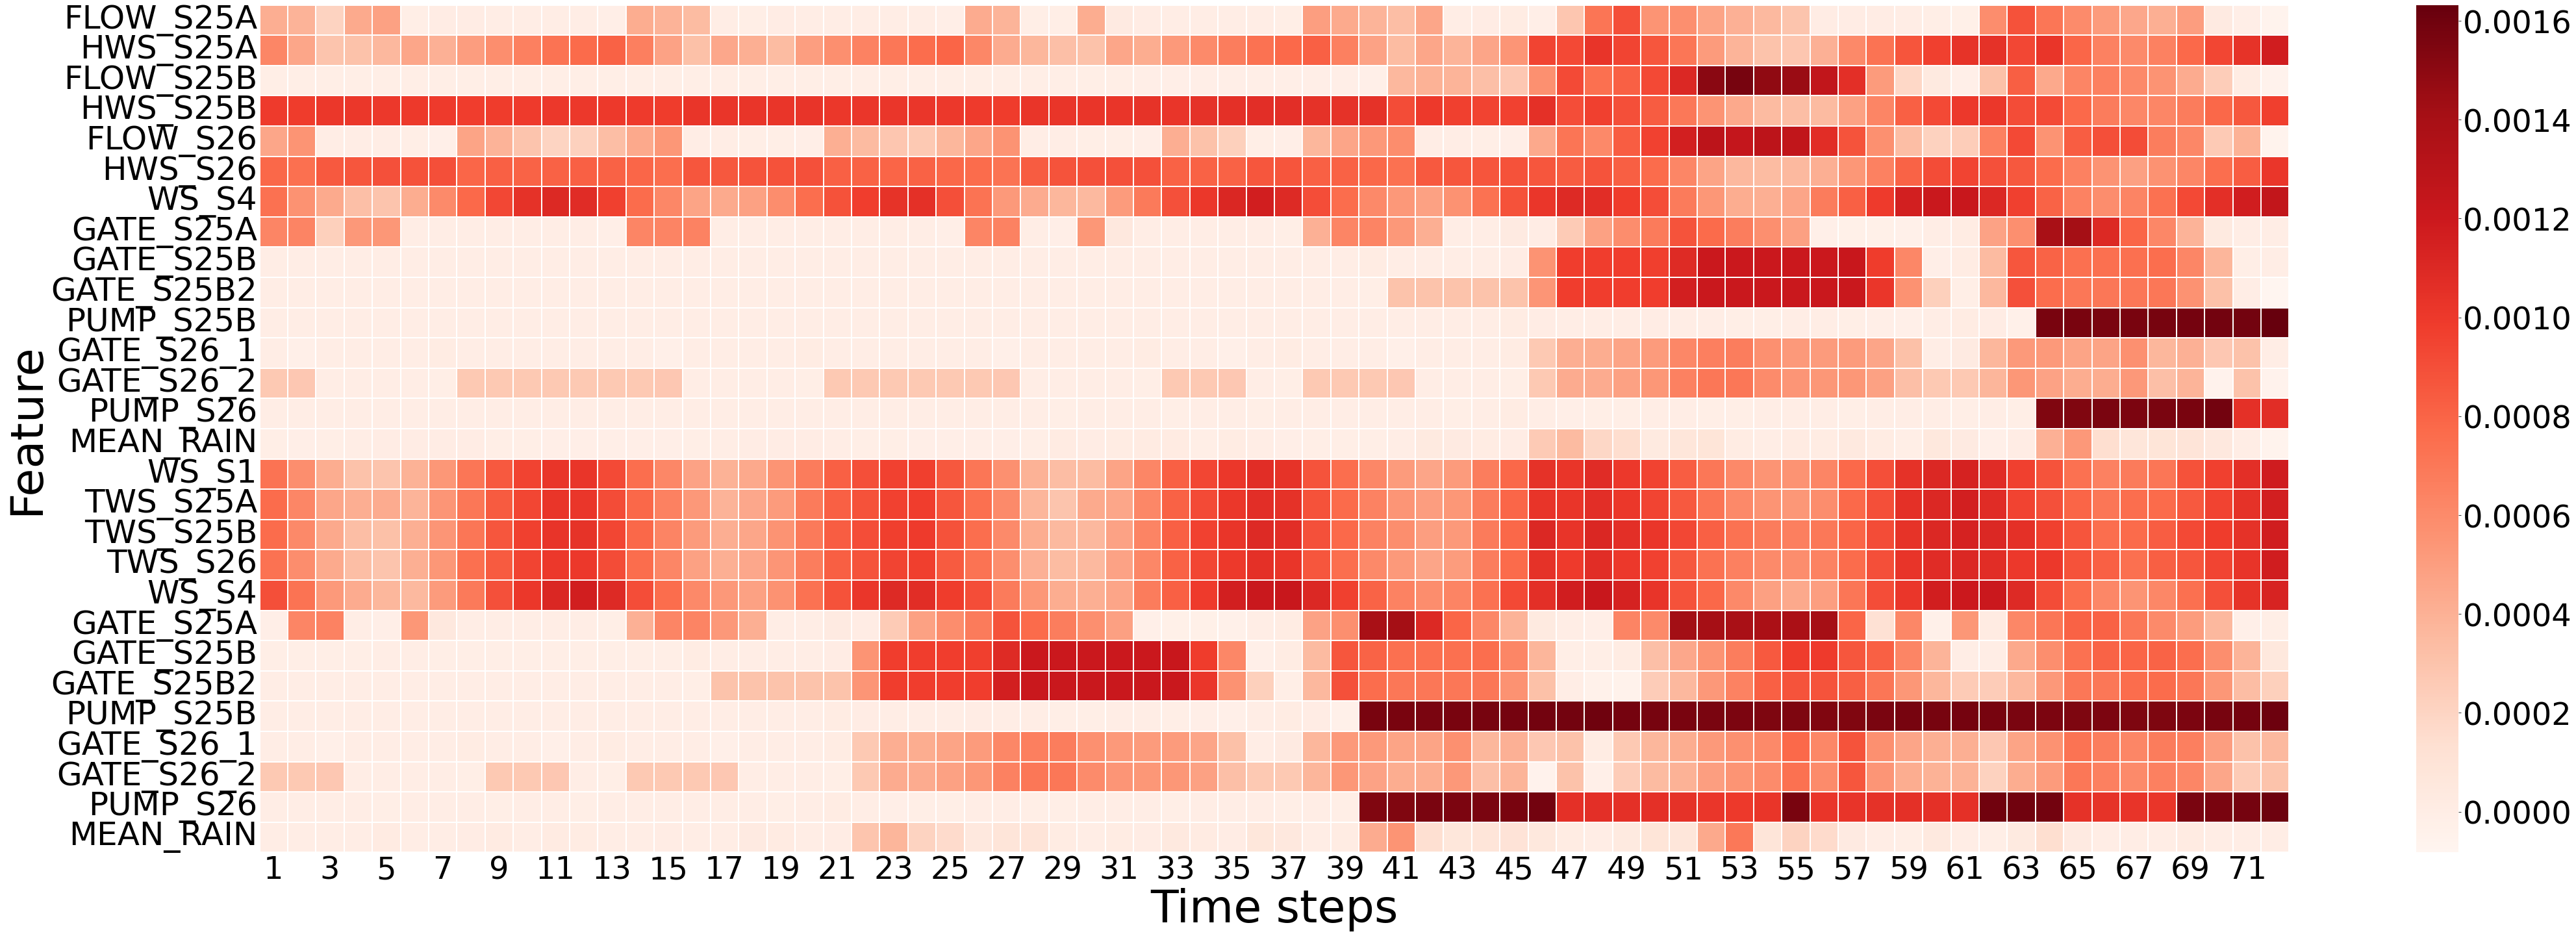

In [39]:
import seaborn as sns

layer_id = -3
for each_test in test_input:
    data = np.expand_dims(each_test, 0)
    heatmap = grad_cam(layer_id, data, saved_model)
    print("heatmap====.shape: ", heatmap.shape)
    print(type(heatmap))
    
    heatmap = np.array(heatmap)
    print(type(heatmap))
    
    # a = np.expand_dims(heatmap, axis=2)
    plt.figure(figsize=(70, 24))
    ax = sns.heatmap(heatmap.T, 
                     linewidth=0.1, 
                     cmap='Reds', 
                     cbar_kws={"shrink": 1},
                     #annot=True, annot_kws={"size":8}
                    )
    
    ax.set_xlabel('Time steps', fontsize=70)
    ax.set_ylabel('Feature', fontsize=70)
    
    ax.set_yticklabels(['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',
                        'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 
                        'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN',
                        
                        'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26',
                        
                        'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',
                        'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'
                       
                       ], 
                       rotation = 0, fontsize=50)
    
    ax.set_xticks([i-0.5 for i in range(1, 73, 2)])
    ax.set_xticklabels([i for i in range(1, 73, 2)], rotation=0, fontsize=48)
    
    ax.tick_params(axis="both", length=0)  # hide ticks
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=48)
    
    #plt.savefig('model_interpretability.png', dpi=300, bbox_inches='tight')
    plt.show()

In [80]:
vis_test_X.shape

(19268, 2016)

In [81]:
vis_test_X_reshape = vis_test_X.reshape((-1, 72, 28))
vis_test_X_reshape.shape

(19268, 72, 28)

In [82]:
vis_test_X_input = vis_test_X_reshape[13998:13999]
vis_test_X_input.shape

(1, 72, 28)

In [84]:
vis_test_X_input = vis_test_X_input[0, :, :]
vis_test_X_input.shape

(72, 28)

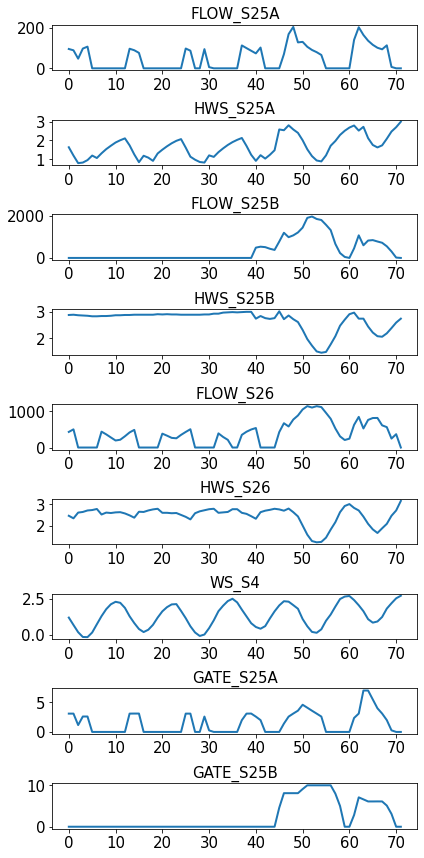

In [113]:


import matplotlib.gridspec as gridspec
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


plt.rcParams["figure.figsize"] = (6, 12)
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(9, 1)

original_features_1_9 = ['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',
                        'WS_S4', 'GATE_S25A', 'GATE_S25B'                       
                       ]

for i in range(len(original_features_1_9)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(vis_test_X_input[:, i], linewidth=2)
    ax.set_title('{}'.format(original_features_1_9[i]), fontsize=15)
    

fig.align_labels()
plt.savefig('vis_original_1_9.png', dpi=300, bbox_inches='tight')
plt.show()

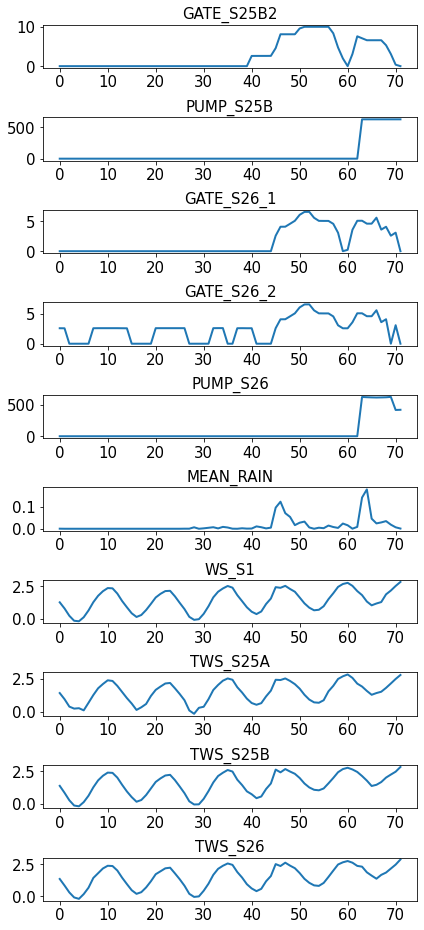

In [115]:
import matplotlib.gridspec as gridspec
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


plt.rcParams["figure.figsize"] = (6, 13)
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(10, 1)

original_features_10_19 = ['GATE_S25B2', 'PUMP_S25B', 
                        'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN',
                        'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26',                        
                       ]

for i in range(len(original_features_10_19)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(vis_test_X_input[:, i+9], linewidth=2)
    ax.set_title('{}'.format(original_features_10_19[i]), fontsize=15)
    

fig.align_labels()
plt.savefig('vis_original_10_19.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 


plt.rcParams["figure.figsize"] = (6, 12)
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(9, 1)

shifted_features = ['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',
                        'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']

for i in range(len(shifted_features)):
    ax = fig.add_subplot(gs[i, :])
    ax.plot(vis_test_X_input[:, i+19], linewidth=2)
    ax.set_title('{}'.format(shifted_features[i]), fontsize=15)
    

fig.align_labels()
plt.savefig('vis_shifted.png', dpi=300, bbox_inches='tight')
plt.show()